In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [2]:
env = gym.make('CartPole-v1')


learning_rate = 0.01
gamma = 0.99

In [3]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        
        self.l1 = nn.Linear(self.state_space, 128, bias = False)
        self.l2 = nn.Linear(128, self.action_space, bias = False)
        
        self.gamma = gamma
        
        self.policy_history = []
        self.reward_episode = []
        self.reward_history = []
        self.loss_history = []
        
    def forward(self, x):
        model = torch.nn.Sequential(
            self.l1,
            nn.Dropout(0.6),
            nn.ReLU(),
            self.l2,
            nn.Softmax(dim = -1)
        )
        return model(x)

In [4]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr = learning_rate)

In [5]:
def select_action(state):
    state = torch.from_numpy(state).type(torch.FloatTensor)
    state = policy(Variable(state))
    c = Categorical(state)
    action = c.sample()

    policy.policy_history.append(c.log_prob(action))
    return action

In [6]:
def update_policy():
    R = 0
    rewards = []
    policy_loss = []

    for r in policy.reward_episode:
        R = r + policy.gamma * R
        rewards.insert(0, R)
    
    rewards = torch.FloatTensor(rewards)
    rewards = (rewards - rewards.mean())/(rewards.std() + np.finfo(np.float32).eps)
    
    for log_prob, R in zip(policy.policy_history, rewards):
        policy_loss.append(-log_prob * R)
    loss = sum(policy_loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    policy.loss_history.append(loss)
    policy.reward_history.append(np.sum(policy.reward_episode))
    policy.policy_history = []
    policy.reward_episode = []

In [7]:
def main(episodes):
    running_reward = 10
    for episode in range(episodes):
        state = env.reset()
        done = False
        
        for time in range(1000):
            #env.render()
            action = select_action(state)
            state, reward, done, _ = env.step(action.numpy())
            
            policy.reward_episode.append(reward)
            if done:
                break
        running_reward = (running_reward * 0.95) + (time * 0.05)
        update_policy()
        
        if episode % 50 == 0:
            print('Episode {}\tLast length: {:5d}\tAverage length: {:.2f}'.format(episode, time, running_reward))
        
        if running_reward > env.spec.reward_threshold:
            print("Solved! Running reward is now {} and the last episode runs to {} time steps!".format(running_reward, time))
            break

In [8]:
episodes = 1000
main(episodes)

Episode 0	Last length:    19	Average length: 10.45
Episode 50	Last length:   236	Average length: 77.56
Episode 100	Last length:   265	Average length: 180.40
Episode 150	Last length:   236	Average length: 333.89
Episode 200	Last length:   116	Average length: 255.29
Episode 250	Last length:   499	Average length: 429.76
Solved! Running reward is now 476.04353181856743 and the last episode runs to 499 time steps!


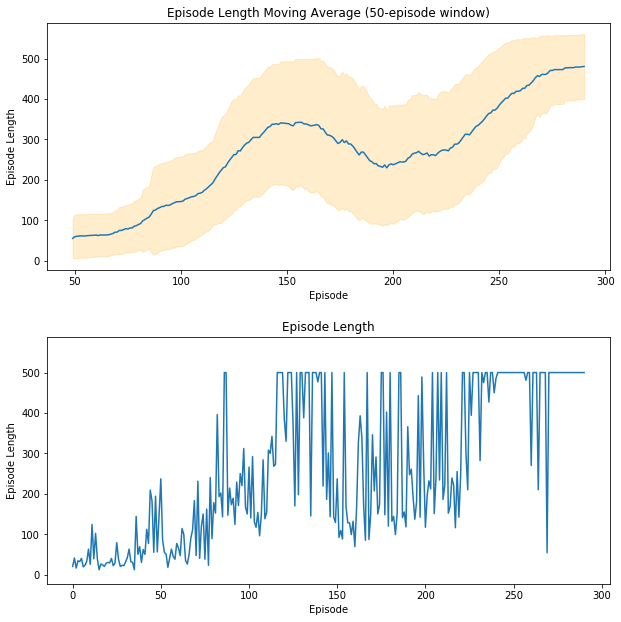

In [9]:
window = int(episodes/20)

fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9,9]);
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
std = pd.Series(policy.reward_history).rolling(window).std()
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)),rolling_mean-std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title('Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode'); ax1.set_ylabel('Episode Length')

ax2.plot(policy.reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode'); ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()